In [26]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:99% !important; }</style>"))

/tmp/ipykernel_8604/956813560.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [4]:
%matplotlib inline
#%config InlineBackend.figure_format = 'retina'
%load_ext autoreload

%autoreload 2

import numpy as np

import matplotlib
matplotlib.rcParams.update({'font.size': 19})

import matplotlib.pyplot as plt
import os, glob, json
import scipy.linalg as sl
import enterprise
from enterprise.pulsar import Pulsar
import enterprise.signals.parameter as parameter
from enterprise.signals import utils
from enterprise.signals import signal_base
from enterprise.signals import selections
from enterprise.signals.selections import Selection
from enterprise.signals import white_signals
from enterprise.signals import gp_signals
from enterprise.signals import deterministic_signals
import enterprise.constants as const

import enterprise_extensions
from enterprise_extensions import blocks

from QuickBurst import QuickBurst_MCMC as QB_MCMC

import healpy as hp

import libstempo as T2
import libstempo.toasim as LT
import libstempo.plot as LP
import re

import pickle

from QuickBurst import tau_scans_pta

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


ModuleNotFoundError: No module named 'tau_scans_pta'

# Setup

In [3]:
parDir = '/home/user/.../Pars/'
timDir =  "/home/user/.../Tims/"

parfiles = sorted(glob.glob(parDir + '*.par'))
timfiles = sorted(glob.glob(timDir + "*.tim"))

psrs = []
for p, t in zip(parfiles, timfiles):
    psr = Pulsar(p, t, ephem=None, clk=None)
    psrs.append(psr)

/home/reyna/BayesHopperBurst/QuickBurst/15_year_A4Cast/Data/Paper_Datasets/Simple_20Psr_30Mpc_parabolic_flyby/CURN_largeA_13_3_skyshift/FakePars/
/home/reyna/BayesHopperBurst/QuickBurst/15_year_A4Cast/Data/Paper_Datasets/Simple_20Psr_30Mpc_parabolic_flyby/CURN_largeA_13_3_skyshift/FakeTims/


[tempo2Util.C:396] Warning: [TIM1] Please place MODE flags in the parameter file 
[tempo2Util.C:401] Warning: [DUP1] duplicated warnings have been suppressed.


In [4]:
'''can save generated pulsars as a pickle for future use'''
# pkl_path = "/home/user/filepath.../"
# os.makedirs(pkl_path,exist_ok=True)
# with open(pkl_path + "Psrs_pkl.pkl", 'wb') as f: #_old_pars
#     pickle.dump(psrs, f)

In [ ]:
'''Load in pulsar pickle files'''
# pkl_path = "home/user/filepath.../"
# with open(pkl_path + "Psrs_pkl.pkl", 'rb') as f:
#     psrs = pickle.load(f)

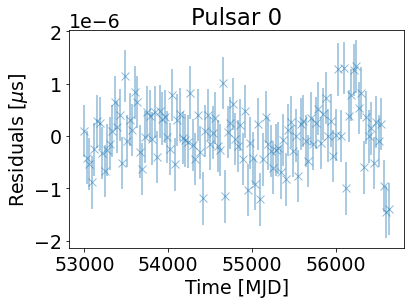

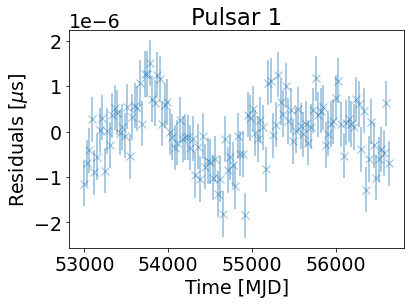

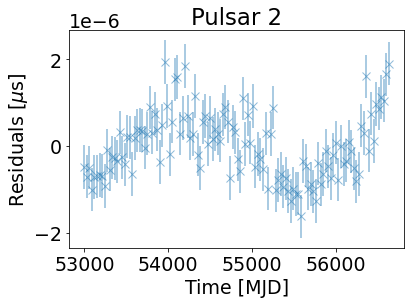

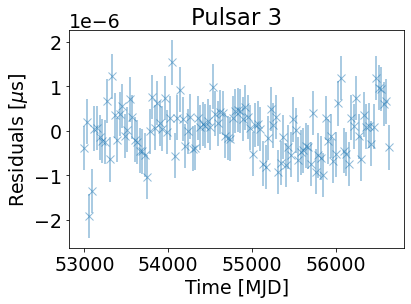

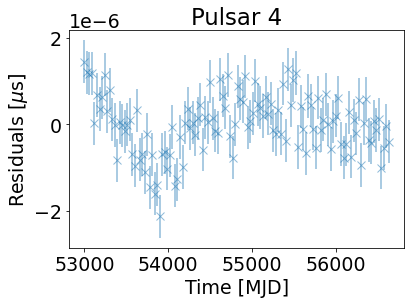

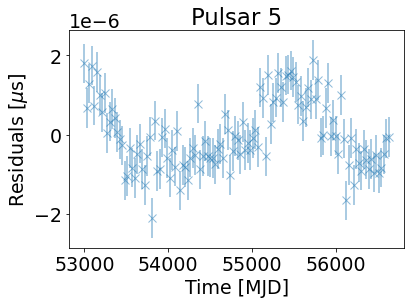

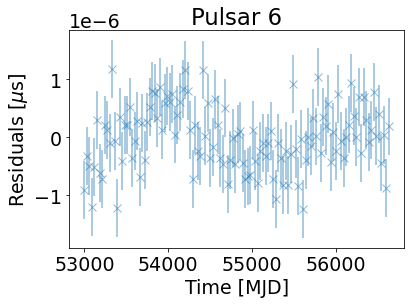

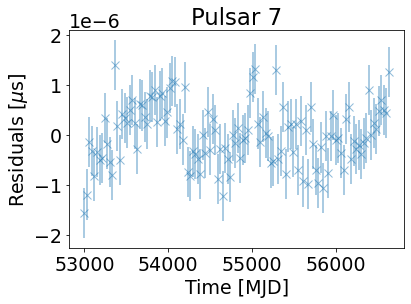

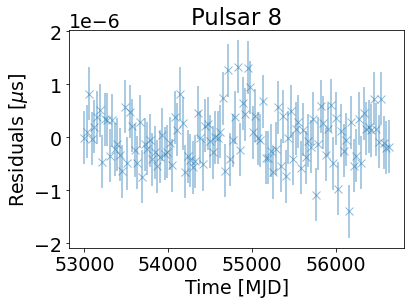

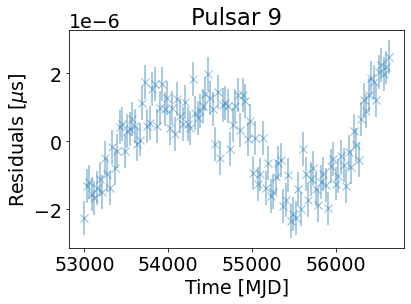

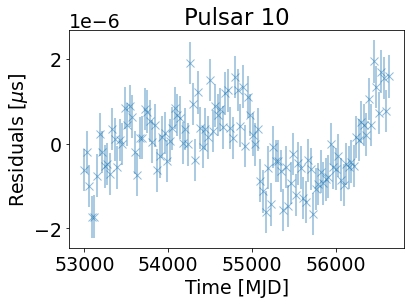

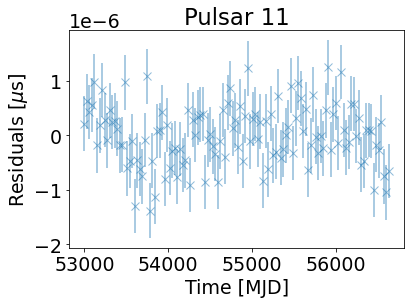

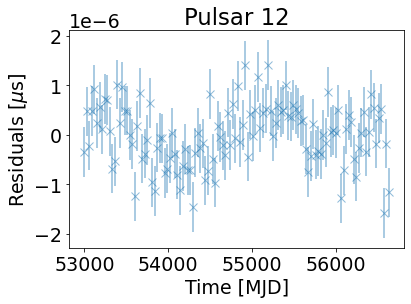

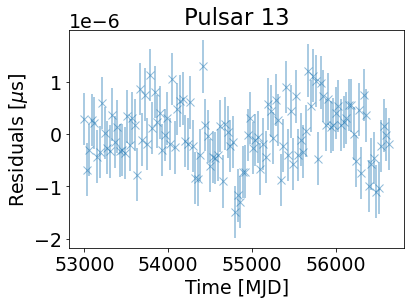

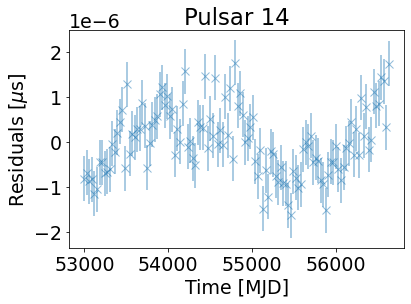

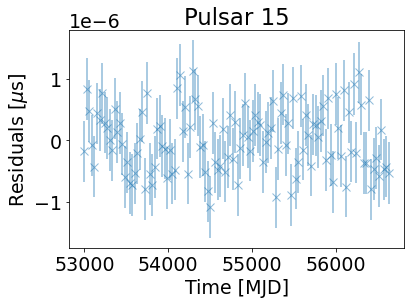

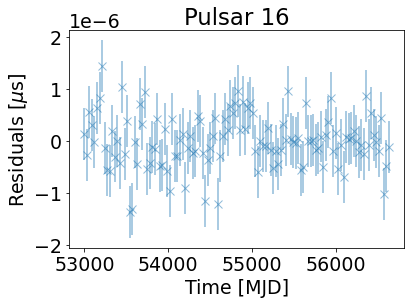

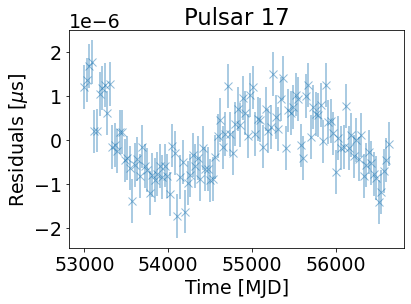

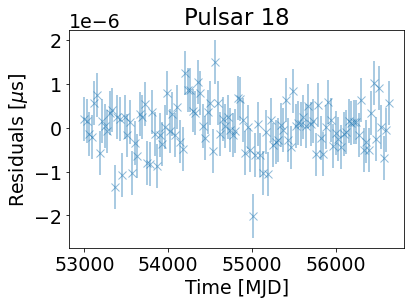

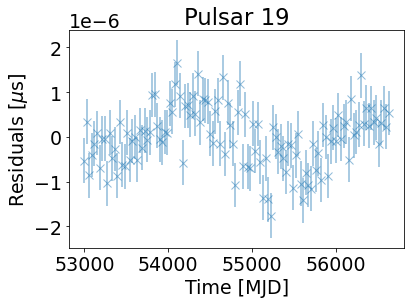

In [8]:
### Visualize data
for i, psr in enumerate(psrs):
    plt.figure(i)      
    plt.errorbar(psr.toas/86400,
            psr.residuals,
            yerr=0.5*10**(-6),#psr.toaerrs[mk],
            markersize=8, ls='', marker='x', alpha=0.5)
    plt.xlabel('Time [MJD]')
    plt.ylabel(r'Residuals [$\mu$s]')
    plt.title('Pulsar {}'.format(i))
    plt.show()

In [13]:
#plotting for more complicated dataset pulsars
ng_frontends=['327', '430', 'Rcvr_800', 'Rcvr1_2', 'L-wide', 'S-wide', '1.5GHz', '3GHz']
for i, psr in enumerate(psrs):
    fe_masks = {}
    fe_resids = {}
    psr_fe = np.unique(psr.flags['fe'])
    resids = psr.residuals
    #plt.plot(psr.toas(),resids)
#     print(psr.name)
    plt.figure(i)
    for fe in ng_frontends:
        if fe in psr_fe:
            fe_masks[fe] = np.array(psr.flags['fe']==fe)
            mk = fe_masks[fe]
            plt.errorbar(psr.toas[mk],
                    psr.residuals[mk]*1e6,
                    yerr=0.0,#psr.toaerrs[mk],
                    markersize=8, ls='', marker='x', label=fe, alpha=0.5)
            plt.xlim(tref, maximum)
            plt.title(psr.name)
            #plt.axvline(psr.toas[0]+1423*(86400))
    plt.legend()
    plt.show()

KeyError: 'fe'

In [4]:
#load in noise file for dataset
noise_file = "home/user/filepath.../params.json"
with open(noise_file, 'r') as h:
    noise_params = json.load(h)

In [ ]:
#check noise parameters to ensure all relevant noise models are being fixed
noise_params

# Individual glitch tau scans

In [ ]:
#Finding reference time for dataset
maximum = 0
minimum = np.inf
for psr in psrs:
    if psr.toas.max() > maximum:
        maximum = psr.toas.max()
    if psr.toas.min() < minimum:
        minimum = psr.toas.min()


#Sets reference time
tref = minimum

t0_max = (maximum - minimum)/365/24/3600
print(t0_max)

In [17]:
####Setting ranges for shape parameters

#frequency range (Hz)
f_max = 1e-7
f_min = 3.5e-9

#centrtal time range (years)
t_max = t0_max
t_min = 0.0

#tau range (envelope size, years)
tau_min = 0.2
tau_max = 5.0

In [18]:
#frequency of wave with a period equal to envelope width
1/(tau_max*365*24*3600)

6.341958396752917e-09

In [20]:
TS_all = {} #will hold individual pulsar Tau Scans
tau_scan = 0
for i in range(len(psrs)):
    # generate a pta for each pulsar individualy
    x = QB_MCMC.get_pta([psrs[i],], vary_white_noise=False, include_equad=True,
                            include_ecorr = False, include_efac = True, 
                            wn_backend_selection=False, noisedict=noise_dict, include_rn=False,
                            vary_rn=False, include_per_psr_rn=False, vary_per_psr_rn=False,
                            max_n_wavelet=5, efac_start = None, rn_amp_prior='log-uniform',
                            rn_log_amp_range=[-18,-11], per_psr_rn_amp_prior='log-uniform',
                            per_psr_rn_log_amp_range=[-18,-11], wavelet_amp_prior='uniform',
                            wavelet_log_amp_range=[-10.0,-5], prior_recovery=False,
                            max_n_glitch=1, glitch_amp_prior='uniform', glitch_log_amp_range=[-10.0,-5],
                            t0_min=0.0, t0_max=t0_max, f0_min=f_min, f0_max=f_max,
                            TF_prior=None, tref=tref)

    #Performs tau scans for each pulsar individually (noise transients)

    TauScan = tau_scans_pta.TauScan([psrs[i],], params=noise_params, pta=x[0])
    TS_dict = tau_scans_pta.make_tau_scan_map(TauScan, f_min=f_min, f_max=f_max, t_min=t_min, t_max=t_max,
                                tau_min=tau_min, tau_max=tau_max)
    TS_all['tau_edges'] = TS_dict['tau_edges'] #why saved every time?
    TS_all['t0_edges'] = TS_dict['t0_edges']
    TS_all['f0_edges'] = TS_dict['f0_edges']
    TS_all['tau_scan'+str(i)] = TS_dict['tau_scan']

get_pta ent_lnlike_test:  False
enterprise v3.3.3,  Python v3.9.12

Signal Name                              Signal Class                   no. Parameters      
JPSR00_linear_timing_model_svd           TimingModel                    0                   

params:
__________________________________________________________________________________________
JPSR00_measurement_noise                 MeasurementNoise               0                   

params:
JPSR00_efac:Constant=1.0                                                                  
JPSR00_log10_t2equad:Constant=-17                                                         
__________________________________________________________________________________________
JPSR00_com_rn                            FourierBasisGP                 0                   

params:
gw_crn_log10_A:Constant=-14.045638789474289                                               
gw_crn_gamma:Constant=3.9631095225441486                                      

4  /  5
40
11
SUM:  440
5  /  5
77
6
SUM:  462
get_pta ent_lnlike_test:  False
enterprise v3.3.3,  Python v3.9.12

Signal Name                              Signal Class                   no. Parameters      
JPSR01_linear_timing_model_svd           TimingModel                    0                   

params:
__________________________________________________________________________________________
JPSR01_measurement_noise                 MeasurementNoise               0                   

params:
JPSR01_efac:Constant=1.0                                                                  
JPSR01_log10_t2equad:Constant=-17                                                         
__________________________________________________________________________________________
JPSR01_com_rn                            FourierBasisGP                 0                   

params:
gw_crn_log10_A:Constant=-14.045638789474289                                               
gw_crn_gamma:Constant=3.9631095

2  /  5
11
42
SUM:  462
3  /  5
21
22
SUM:  462
4  /  5
40
11
SUM:  440
5  /  5
77
6
SUM:  462
get_pta ent_lnlike_test:  False
enterprise v3.3.3,  Python v3.9.12

Signal Name                              Signal Class                   no. Parameters      
JPSR02_linear_timing_model_svd           TimingModel                    0                   

params:
__________________________________________________________________________________________
JPSR02_measurement_noise                 MeasurementNoise               0                   

params:
JPSR02_efac:Constant=1.0                                                                  
JPSR02_log10_t2equad:Constant=-17                                                         
__________________________________________________________________________________________
JPSR02_com_rn                            FourierBasisGP                 0                   

params:
gw_crn_log10_A:Constant=-14.045638789474289                               

3  /  5
21
22
SUM:  462
4  /  5
40
11
SUM:  440
5  /  5
77
6
SUM:  462
get_pta ent_lnlike_test:  False
enterprise v3.3.3,  Python v3.9.12

Signal Name                              Signal Class                   no. Parameters      
JPSR03_linear_timing_model_svd           TimingModel                    0                   

params:
__________________________________________________________________________________________
JPSR03_measurement_noise                 MeasurementNoise               0                   

params:
JPSR03_efac:Constant=1.0                                                                  
JPSR03_log10_t2equad:Constant=-17                                                         
__________________________________________________________________________________________
JPSR03_com_rn                            FourierBasisGP                 0                   

params:
gw_crn_log10_A:Constant=-14.045638789474289                                               
gw_crn_

4  /  5
40
11
SUM:  440
5  /  5
77
6
SUM:  462
get_pta ent_lnlike_test:  False
enterprise v3.3.3,  Python v3.9.12

Signal Name                              Signal Class                   no. Parameters      
JPSR04_linear_timing_model_svd           TimingModel                    0                   

params:
__________________________________________________________________________________________
JPSR04_measurement_noise                 MeasurementNoise               0                   

params:
JPSR04_efac:Constant=1.0                                                                  
JPSR04_log10_t2equad:Constant=-17                                                         
__________________________________________________________________________________________
JPSR04_com_rn                            FourierBasisGP                 0                   

params:
gw_crn_log10_A:Constant=-14.045638789474289                                               
gw_crn_gamma:Constant=3.9631095

2  /  5
11
42
SUM:  462
3  /  5
21
22
SUM:  462
4  /  5
40
11
SUM:  440
5  /  5
77
6
SUM:  462
get_pta ent_lnlike_test:  False
enterprise v3.3.3,  Python v3.9.12

Signal Name                              Signal Class                   no. Parameters      
JPSR05_linear_timing_model_svd           TimingModel                    0                   

params:
__________________________________________________________________________________________
JPSR05_measurement_noise                 MeasurementNoise               0                   

params:
JPSR05_efac:Constant=1.0                                                                  
JPSR05_log10_t2equad:Constant=-17                                                         
__________________________________________________________________________________________
JPSR05_com_rn                            FourierBasisGP                 0                   

params:
gw_crn_log10_A:Constant=-14.045638789474289                               

2  /  5
11
42
SUM:  462
3  /  5
21
22
SUM:  462
4  /  5
40
11
SUM:  440
5  /  5
77
6
SUM:  462
get_pta ent_lnlike_test:  False
enterprise v3.3.3,  Python v3.9.12

Signal Name                              Signal Class                   no. Parameters      
JPSR06_linear_timing_model_svd           TimingModel                    0                   

params:
__________________________________________________________________________________________
JPSR06_measurement_noise                 MeasurementNoise               0                   

params:
JPSR06_efac:Constant=1.0                                                                  
JPSR06_log10_t2equad:Constant=-17                                                         
__________________________________________________________________________________________
JPSR06_com_rn                            FourierBasisGP                 0                   

params:
gw_crn_log10_A:Constant=-14.045638789474289                               

1  /  5
5
80
SUM:  400
2  /  5
11
42
SUM:  462
3  /  5
21
22
SUM:  462
4  /  5
40
11
SUM:  440
5  /  5
77
6
SUM:  462
get_pta ent_lnlike_test:  False
enterprise v3.3.3,  Python v3.9.12

Signal Name                              Signal Class                   no. Parameters      
JPSR07_linear_timing_model_svd           TimingModel                    0                   

params:
__________________________________________________________________________________________
JPSR07_measurement_noise                 MeasurementNoise               0                   

params:
JPSR07_efac:Constant=1.0                                                                  
JPSR07_log10_t2equad:Constant=-17                                                         
__________________________________________________________________________________________
JPSR07_com_rn                            FourierBasisGP                 0                   

params:
gw_crn_log10_A:Constant=-14.045638789474289        

2  /  5
11
42
SUM:  462
3  /  5
21
22
SUM:  462
4  /  5
40
11
SUM:  440
5  /  5
77
6
SUM:  462
get_pta ent_lnlike_test:  False
enterprise v3.3.3,  Python v3.9.12

Signal Name                              Signal Class                   no. Parameters      
JPSR08_linear_timing_model_svd           TimingModel                    0                   

params:
__________________________________________________________________________________________
JPSR08_measurement_noise                 MeasurementNoise               0                   

params:
JPSR08_efac:Constant=1.0                                                                  
JPSR08_log10_t2equad:Constant=-17                                                         
__________________________________________________________________________________________
JPSR08_com_rn                            FourierBasisGP                 0                   

params:
gw_crn_log10_A:Constant=-14.045638789474289                               

2  /  5
11
42
SUM:  462
3  /  5
21
22
SUM:  462
4  /  5
40
11
SUM:  440
5  /  5
77
6
SUM:  462
get_pta ent_lnlike_test:  False
enterprise v3.3.3,  Python v3.9.12

Signal Name                              Signal Class                   no. Parameters      
JPSR09_linear_timing_model_svd           TimingModel                    0                   

params:
__________________________________________________________________________________________
JPSR09_measurement_noise                 MeasurementNoise               0                   

params:
JPSR09_efac:Constant=1.0                                                                  
JPSR09_log10_t2equad:Constant=-17                                                         
__________________________________________________________________________________________
JPSR09_com_rn                            FourierBasisGP                 0                   

params:
gw_crn_log10_A:Constant=-14.045638789474289                               

3  /  5
21
22
SUM:  462
4  /  5
40
11
SUM:  440
5  /  5
77
6
SUM:  462
get_pta ent_lnlike_test:  False
enterprise v3.3.3,  Python v3.9.12

Signal Name                              Signal Class                   no. Parameters      
JPSR10_linear_timing_model_svd           TimingModel                    0                   

params:
__________________________________________________________________________________________
JPSR10_measurement_noise                 MeasurementNoise               0                   

params:
JPSR10_efac:Constant=1.0                                                                  
JPSR10_log10_t2equad:Constant=-17                                                         
__________________________________________________________________________________________
JPSR10_com_rn                            FourierBasisGP                 0                   

params:
gw_crn_log10_A:Constant=-14.045638789474289                                               
gw_crn_

4  /  5
40
11
SUM:  440
5  /  5
77
6
SUM:  462
get_pta ent_lnlike_test:  False
enterprise v3.3.3,  Python v3.9.12

Signal Name                              Signal Class                   no. Parameters      
JPSR11_linear_timing_model_svd           TimingModel                    0                   

params:
__________________________________________________________________________________________
JPSR11_measurement_noise                 MeasurementNoise               0                   

params:
JPSR11_efac:Constant=1.0                                                                  
JPSR11_log10_t2equad:Constant=-17                                                         
__________________________________________________________________________________________
JPSR11_com_rn                            FourierBasisGP                 0                   

params:
gw_crn_log10_A:Constant=-14.045638789474289                                               
gw_crn_gamma:Constant=3.9631095

2  /  5
11
42
SUM:  462
3  /  5
21
22
SUM:  462
4  /  5
40
11
SUM:  440
5  /  5
77
6
SUM:  462
get_pta ent_lnlike_test:  False
enterprise v3.3.3,  Python v3.9.12

Signal Name                              Signal Class                   no. Parameters      
JPSR12_linear_timing_model_svd           TimingModel                    0                   

params:
__________________________________________________________________________________________
JPSR12_measurement_noise                 MeasurementNoise               0                   

params:
JPSR12_efac:Constant=1.0                                                                  
JPSR12_log10_t2equad:Constant=-17                                                         
__________________________________________________________________________________________
JPSR12_com_rn                            FourierBasisGP                 0                   

params:
gw_crn_log10_A:Constant=-14.045638789474289                               

3  /  5
21
22
SUM:  462
4  /  5
40
11
SUM:  440
5  /  5
77
6
SUM:  462
get_pta ent_lnlike_test:  False
enterprise v3.3.3,  Python v3.9.12

Signal Name                              Signal Class                   no. Parameters      
JPSR13_linear_timing_model_svd           TimingModel                    0                   

params:
__________________________________________________________________________________________
JPSR13_measurement_noise                 MeasurementNoise               0                   

params:
JPSR13_efac:Constant=1.0                                                                  
JPSR13_log10_t2equad:Constant=-17                                                         
__________________________________________________________________________________________
JPSR13_com_rn                            FourierBasisGP                 0                   

params:
gw_crn_log10_A:Constant=-14.045638789474289                                               
gw_crn_

4  /  5
40
11
SUM:  440
5  /  5
77
6
SUM:  462
get_pta ent_lnlike_test:  False
enterprise v3.3.3,  Python v3.9.12

Signal Name                              Signal Class                   no. Parameters      
JPSR14_linear_timing_model_svd           TimingModel                    0                   

params:
__________________________________________________________________________________________
JPSR14_measurement_noise                 MeasurementNoise               0                   

params:
JPSR14_efac:Constant=1.0                                                                  
JPSR14_log10_t2equad:Constant=-17                                                         
__________________________________________________________________________________________
JPSR14_com_rn                            FourierBasisGP                 0                   

params:
gw_crn_log10_A:Constant=-14.045638789474289                                               
gw_crn_gamma:Constant=3.9631095

2  /  5
11
42
SUM:  462
3  /  5
21
22
SUM:  462
4  /  5
40
11
SUM:  440
5  /  5
77
6
SUM:  462
get_pta ent_lnlike_test:  False
enterprise v3.3.3,  Python v3.9.12

Signal Name                              Signal Class                   no. Parameters      
JPSR15_linear_timing_model_svd           TimingModel                    0                   

params:
__________________________________________________________________________________________
JPSR15_measurement_noise                 MeasurementNoise               0                   

params:
JPSR15_efac:Constant=1.0                                                                  
JPSR15_log10_t2equad:Constant=-17                                                         
__________________________________________________________________________________________
JPSR15_com_rn                            FourierBasisGP                 0                   

params:
gw_crn_log10_A:Constant=-14.045638789474289                               

3  /  5
21
22
SUM:  462
4  /  5
40
11
SUM:  440
5  /  5
77
6
SUM:  462
get_pta ent_lnlike_test:  False
enterprise v3.3.3,  Python v3.9.12

Signal Name                              Signal Class                   no. Parameters      
JPSR16_linear_timing_model_svd           TimingModel                    0                   

params:
__________________________________________________________________________________________
JPSR16_measurement_noise                 MeasurementNoise               0                   

params:
JPSR16_efac:Constant=1.0                                                                  
JPSR16_log10_t2equad:Constant=-17                                                         
__________________________________________________________________________________________
JPSR16_com_rn                            FourierBasisGP                 0                   

params:
gw_crn_log10_A:Constant=-14.045638789474289                                               
gw_crn_

4  /  5
40
11
SUM:  440
5  /  5
77
6
SUM:  462
get_pta ent_lnlike_test:  False
enterprise v3.3.3,  Python v3.9.12

Signal Name                              Signal Class                   no. Parameters      
JPSR17_linear_timing_model_svd           TimingModel                    0                   

params:
__________________________________________________________________________________________
JPSR17_measurement_noise                 MeasurementNoise               0                   

params:
JPSR17_efac:Constant=1.0                                                                  
JPSR17_log10_t2equad:Constant=-17                                                         
__________________________________________________________________________________________
JPSR17_com_rn                            FourierBasisGP                 0                   

params:
gw_crn_log10_A:Constant=-14.045638789474289                                               
gw_crn_gamma:Constant=3.9631095

2  /  5
11
42
SUM:  462
3  /  5
21
22
SUM:  462
4  /  5
40
11
SUM:  440
5  /  5
77
6
SUM:  462
get_pta ent_lnlike_test:  False
enterprise v3.3.3,  Python v3.9.12

Signal Name                              Signal Class                   no. Parameters      
JPSR18_linear_timing_model_svd           TimingModel                    0                   

params:
__________________________________________________________________________________________
JPSR18_measurement_noise                 MeasurementNoise               0                   

params:
JPSR18_efac:Constant=1.0                                                                  
JPSR18_log10_t2equad:Constant=-17                                                         
__________________________________________________________________________________________
JPSR18_com_rn                            FourierBasisGP                 0                   

params:
gw_crn_log10_A:Constant=-14.045638789474289                               

3  /  5
21
22
SUM:  462
4  /  5
40
11
SUM:  440
5  /  5
77
6
SUM:  462
get_pta ent_lnlike_test:  False
enterprise v3.3.3,  Python v3.9.12

Signal Name                              Signal Class                   no. Parameters      
JPSR19_linear_timing_model_svd           TimingModel                    0                   

params:
__________________________________________________________________________________________
JPSR19_measurement_noise                 MeasurementNoise               0                   

params:
JPSR19_efac:Constant=1.0                                                                  
JPSR19_log10_t2equad:Constant=-17                                                         
__________________________________________________________________________________________
JPSR19_com_rn                            FourierBasisGP                 0                   

params:
gw_crn_log10_A:Constant=-14.045638789474289                                               
gw_crn_

4  /  5
40
11
SUM:  440
5  /  5
77
6
SUM:  462


## Saving individual glitch tau scans

In [21]:
# with open("home/user/filepath.../glitch_tau_scan.pkl", 'wb') as f:
#     pickle.dump(TS_all, f)

In [5]:
# with open("home/user/filepath.../glitch_tau_scan.pkl", 'rb') as f:
#     TS_all = pickle.load(f)

## Plotting glitch tau scans

In [ ]:
tau_edges = TS_all['tau_edges']
T0_list = TS_all['t0_edges']
F0_list = TS_all['f0_edges']

for i in range(len(psrs)):
    print(i)
    tau_scan = TS_all['tau_scan'+str(i)]
    scan_max = max([np.nanmax(x) for x in tau_scan])
    print(scan_max)
    for l in range(tau_edges.size-1):
        fig = plt.figure(l+i*(tau_edges.size-1))
        c = plt.gca().pcolormesh(T0_list[l]/24/3600, F0_list[l]/1e-9 ,np.sqrt(tau_scan[l]), vmax=np.sqrt(scan_max), vmin=0.0)
        plt.colorbar(c)
        plt.title("PSR{2:d} -- tau = {0:.2f} - {1:.2f} years".format(tau_edges[l], tau_edges[l+1], i))
        plt.xlabel("t [days]")
        plt.ylabel("f [nHz]")

# Stitching together individual glitch tau scans and saving combined tau scan

In [22]:
TS_dict = {} #holds the wavelet tau scans (combination of all pulsars)

for i in range(len(psrs)):
    glitch_tau_scan_data = np.copy(TS_all['tau_scan{}'.format(i)])
    
    #Only populate tau edges, f0, t0 once. Same for all pulsars
    print('Pulsar {}'.format(i))
    if i==0:
        TS_dict['tau_edges'] = TS_all['tau_edges']
        TS_dict['f0_edges'] = TS_all['f0_edges']
        TS_dict['t0_edges'] = TS_all['t0_edges']
        TS_dict['tau_scan'] = glitch_tau_scan_data
    
    #Otherwise, stitch together tau scans for each pulsar to get wavelet tau scans
    else:
        for j in range(len(TS_dict['tau_scan'])):
            ts = glitch_tau_scan_data
            TS_dict['tau_scan'][j] += np.where(np.isnan(ts[j]), 0.0, ts[j])

Pulsar 0
Pulsar 1
Bin: 0
14.090525775941956
Bin: 1
13.253826116871604
Bin: 2
12.949528098612728
Bin: 3
12.21195426706289
Bin: 4
11.25916478191095


Pulsar 2
Bin: 0
18.486487140920865
Bin: 1
23.910988378518425
Bin: 2
23.678181501106156
Bin: 3
24.07330928190642
Bin: 4
22.135895330095856


Pulsar 3
Bin: 0
25.462623688185076
Bin: 1
28.090086804460732
Bin: 2
28.111585573093617
Bin: 3
27.408779450177857
Bin: 4
24.17891578383122


Pulsar 4
Bin: 0
29.923572481684406
Bin: 1
30.266948201610905
Bin: 2
28.60724210487474
Bin: 3
28.805174303306902
Bin: 4
26.533935076229223


Pulsar 5
Bin: 0
36.59981433485007
Bin: 1
35.47050693031498
Bin: 2
32.51611236147354
Bin: 3
31.91644347482267
Bin: 4
27.589293104771038


Pulsar 6
Bin: 0
39.70561433866278
Bin: 1
38.405639376641865
Bin: 2
35.0893321299028
Bin: 3
32.700211368744085
Bin: 4
30.13589295586602


Pulsar 7
Bin: 0
42.987683892817394
Bin: 1
41.43279238217453
Bin: 2
36.34020744704139
Bin: 3
35.13838273345398
Bin: 4
31.66256080806508


Pulsar 8
Bin: 0
44.04

/home/reyna/anaconda3/envs/ent/lib/python3.9/site-packages/numpy/lib/function_base.py:935: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, order=order, subok=subok, copy=True)


## Saving stitched together tau scans (i.e. Wavelet tau scans)

In [23]:
# with open("home/user/filepath.../wavelet_tau_scan.pkl", 'wb') as f:
#     pickle.dump(TS_dict, f)

In [7]:
# with open("home/user/filepath.../wavelet_tau_scan.pkl", 'rb') as f:
#     TS_dict = pickle.load(f)

## Plotting wavelet tau scan

79.90084844686245
19
95
96
97
98
99


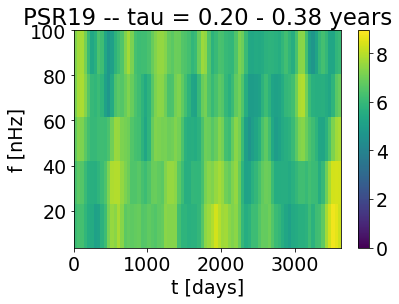

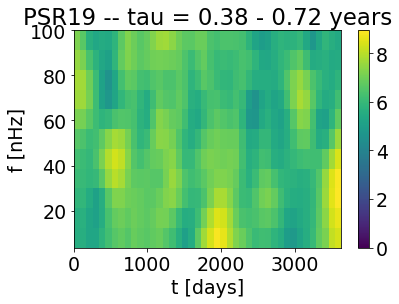

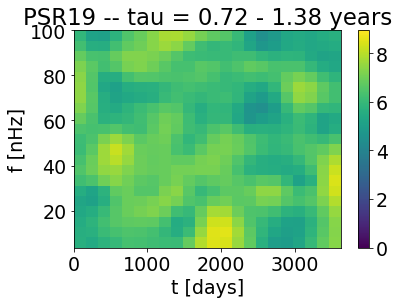

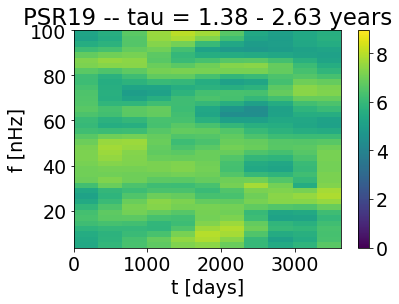

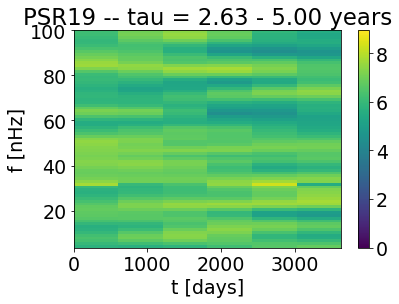

In [24]:
tau_edges = TS_dict['tau_edges']
T0_list = TS_dict['t0_edges']
F0_list = TS_dict['f0_edges']
tau_scan = TS_dict['tau_scan']

scan_max = max([np.nanmax(x) for x in tau_scan])
print(scan_max)

for l in range(tau_edges.size-1):
    fig = plt.figure(l+i*(tau_edges.size-1))
    c = plt.gca().pcolormesh(T0_list[l]/24/3600, F0_list[l]/1e-9 ,np.sqrt(tau_scan[l]), vmax=np.sqrt(scan_max), vmin=0.0)
    plt.colorbar(c)
    plt.title("PSR{2:d} -- tau = {0:.2f} - {1:.2f} years".format(tau_edges[l], tau_edges[l+1], i))
    plt.xlabel("t [days]")
    plt.ylabel("f [nHz]")